<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-loading" data-toc-modified-id="Data-loading-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data loading</a></span><ul class="toc-item"><li><span><a href="#Tropopause" data-toc-modified-id="Tropopause-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Tropopause</a></span></li><li><span><a href="#Anomalies" data-toc-modified-id="Anomalies-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Anomalies</a></span></li><li><span><a href="#EPFD-Significance" data-toc-modified-id="EPFD-Significance-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>EPFD Significance</a></span></li></ul></li><li><span><a href="#Figure-1" data-toc-modified-id="Figure-1-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Figure 1</a></span></li></ul></div>

In [2]:
import glob
import xarray as xr
import xarray.ufuncs as xrf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import shapely.geometry as sgeom


%matplotlib inline

In [1]:
%reload_ext watermark
%watermark --iversions -v -m

CPython 3.6.9
IPython 7.1.1

compiler   : GCC 8.4.0
system     : Linux
release    : 4.15.0-122-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit


In [3]:
timescale = 20
DJF_bool = '_DJFonly'
cesta = '/mnt/4data/CMAM/0A.daily/composites_woSSW{}/'.format(DJF_bool)

In [67]:
def three_row_subplot_fce(carrf, carr, qarr_x, qarr_y, trop_arr, levels, scaling = [], nos_lat = 2, nos_lev = 2):
    lat = qarr_x.lat.values
    lev = qarr_x.plev.values
    lat_start = 0#-20
    lat_end = 90
    

    font_size = 8
    f, xarr = plt.subplots(3, 3, sharex='col', sharey='row', figsize = (16,15))
    #plt.subplots_adjust(right=1.5)

    label_i = 0
    label_ls = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']
    for ri in range(3):
        for ci, sel_e_type in zip(range(3), carr.coords['e_type']):
            ax = xarr[ri,ci]
            label = label_ls[label_i]
            label_i += 1
            #ax.text(-0.1, 1.15, label, transform=ax.transAxes,
            #      fontsize=16, fontweight='bold', va='top', ha='right')
            ax.text(0.05, 0.95, label, transform=ax.transAxes, fontsize = 20, 
                fontweight='bold', va='top', bbox={'alpha': 0.7, 'facecolor': 'white'})
            #contourf plotting of anomalies
            cmap = mpl.cm.PuOr_r#RdBu_r
            carrf.loc[sel_e_type].plot.contourf(x= 'lat', \
                                               y = 'plev', \
                                               yincrease = False, \
                                               cmap = cmap, 
                                               levels = levels, \
                                               add_colorbar = False, ax = ax)
            
            # contour plotting of climatology
            if carrf.name == 'vmro3':
                qk_pos_x, qk_pos_y = 1.2, 1.075
                qk_delta_x = 0#0.18
                qk_pos_x2 = qk_pos_x-qk_delta_x
                qk_pos_y2 = qk_pos_y+0.1
                qk_scale_x = 1
                qk_scale_y = 1
                qk_label_x = r'$1\,\mathrm{m/s}$'
                qk_label_y = r'$1\cdot10^{-3}\,\mathrm{m/s}$'
                plot_kwargs = dict(yincrease = False, \
                       colors = 'grey', \
                       levels = [1e-7,2e-6,4e-6,6e-6,8e-6], add_colorbar=False, alpha =1 )            
                carr.loc[sel_e_type].plot.contour('lat', 'plev', ax = ax, **plot_kwargs)            
            
                plot_kwargs['levels'] = [1e-5]
                plot_kwargs['linewidths'] = 3
                plot_kwargs['alpha'] = 1
                carr.loc[sel_e_type].plot.contour('lat', 'plev', ax = ax, **plot_kwargs)
                label = 'ozone volume mixing ratio [%]'
                ticks = [-4,-3,-2,-1,0,1,2,3,4]
            
            if carrf.name[:8] == 'acceldiv':
                qk_pos_x, qk_pos_y = 1.2, 1.075
                qk_delta_x = 0.08
                qk_pos_x2 = qk_pos_x-qk_delta_x
                qk_pos_y2 = qk_pos_y+0.15
                qk_scale_x = 1.5e7
                qk_scale_y = 1e7
                qk_label_x = r'$1.5 \cdot 10^7\,\mathrm{kg/s/s}$'
                qk_label_y = r'$1 \cdot 10^5\,\mathrm{kg/s/s}$'
                plot_kwargs = dict(yincrease = False, levels=21, robust = True, add_colorbar=False)
                plot_kwargs['colors'] = ['gray']*3
                plot_kwargs['linewidths'] = 2
                plot_kwargs['add_colorbar'] = False
                plot_kwargs['levels']=[0.1,0.5,1,3]
                plot_kwargs['linewidths'] = np.linspace(1,4,len(plot_kwargs['levels']))
                carr.loc[sel_e_type].plot.contour('lat', 'plev', ax = ax, **plot_kwargs)             
                
                plot_kwargs['levels']=[-3,-1,-0.5,-0.1]
                plot_kwargs['linewidths'] = np.linspace(4,1,len(plot_kwargs['levels']))
                plot_kwargs['linestyles'] = 'dashed'
                carr.loc[sel_e_type].plot.contour('lat', 'plev', ax = ax, **plot_kwargs)
                                
                plot_kwargs['levels']=[0]
                plot_kwargs['linestyles'] = 'solid'
                plot_kwargs['linewidths'] = 2
                #carr.loc[sel_e_type].plot.contour('lat', 'plev', ax = ax, **plot_kwargs)
                label = 'EPFD [m/s/day]'
                ticks = [-6,-4,-2,0,2,4,6]

            
            # hotspot visualization
            ax.hlines(70, lat_start, lat_end, color = 'green', linestyles='--', lw = 3)
            if sel_e_type == 'himalayas':
                box = sgeom.box(minx=70, maxx=105, miny=20, maxy=42)
            elif sel_e_type == 'eastasia':
                box = sgeom.box(minx=110, maxx=145, miny=27.5, maxy=52)
            elif sel_e_type == 'westamer':
                box = sgeom.box(minx=-125, maxx=-102.5, miny=27.5, maxy=52)
            ax.vlines(list(box.bounds)[1::2],80,60, color = 'green', linestyles='--', lw = 3)
                
            # tropopause plotting
            ax.plot(lat, trop_arr.loc[sel_e_type], 'k--', lw = 3)  

            ax.set_yscale('log')
            fmt = mpl.ticker.FormatStrFormatter("%g")
            ax.yaxis.set_major_formatter(fmt)
            ax.set_xticks([-20,0,20,40,60,80])
            
            if ci == 2:
                ax2 = ax.twinx()
                ax2.get_shared_y_axes()            
                ax2.tick_params(direction='out', which='both', labelsize=14)
            
    
            if ri == 0:
                plev_start = 2
                plev_end = 0.1
                ax.axis([lat_start, lat_end, plev_start, plev_end])
                ax.set_yticks([1,0.1])                
                ax.set_title(titles[ci], fontdict=dict(fontweight = 'bold', fontsize = 22), y = 1.11)
                ax.set_xlabel('')
                
                # arrow plotting
                Q = ax.quiver(lat[::nos_lat], lev[::nos_lev], qarr_x.loc[sel_e_type].values[::nos_lev,::nos_lat], \
                  qarr_y.loc[sel_e_type].values[::nos_lev,::nos_lat], \
                  pivot='mid', headwidth = 5, scale_units = 'inches', scale = scaling[0])
                
                if ci == 0:
                    qk = ax.quiverkey(Q, qk_pos_x, qk_pos_y, qk_scale_x, qk_label_x, labelpos='E',
                       coordinates='axes', fontproperties=dict(size = font_size))
                    """qk = ax.quiverkey(Q, qk_pos_x2, qk_pos_y2, qk_scale_y, qk_label_y, labelpos='N',
                       coordinates='axes', angle = 90, labelsep = 0.3, fontproperties=dict(size = font_size))"""
                              
                
                if ci == 2:                    
                    ax2.axis([lat_start, 90, 7*np.log(1013.25/plev_start), 7*np.log(1013.25/plev_end)])
                    ax2.set_yticks([45,50,55,60])


            elif ri == 1:
                plev_start = 200
                plev_end = 1
                ax.axis([lat_start, lat_end, plev_start, plev_end])
                ax.set_yticks([100,10,1])
                ax.set_title('')
                ax.set_xlabel('')
                
                # arrow plotting
                Q = ax.quiver(lat[::nos_lat], lev[::nos_lev], qarr_x.loc[sel_e_type].values[::nos_lev,::nos_lat], \
                  qarr_y.loc[sel_e_type].values[::nos_lev,::nos_lat], \
                  pivot='mid', headwidth = 5, scale_units = 'inches', scale = scaling[1]) 
                
                if ci == 0:
                    #if carrf.name == 'acceldiv':
                    qk = ax.quiverkey(Q, qk_pos_x-qk_delta_x, qk_pos_y, qk_scale_x, qk_label_x, labelpos='E',
                           coordinates='axes', fontproperties=dict(size = font_size))
                    """qk = ax.quiverkey(Q, qk_pos_x2, qk_pos_y2*0.9, qk_scale_y, qk_label_y, labelpos='N',
                       coordinates='axes', angle = 90, labelsep = 0.1, fontproperties=dict(size = font_size))"""
                    
                if ci == 2:        
                    ax2.axis([lat_start, 90, 7*np.log(1013.25/plev_start), 7*np.log(1013.25/plev_end)])
                    ax2.set_yticks([15,25,35,45])
                    
            elif ri == 2:
                
                # arrow plotting
                Q = ax.quiver(lat[::nos_lat], lev[::nos_lev], qarr_x.loc[sel_e_type].values[::nos_lev,::nos_lat], \
                  qarr_y.loc[sel_e_type].values[::nos_lev,::nos_lat], \
                  pivot='mid', headwidth = 5, scale_units = 'inches', scale = scaling[2])
                    
                
                plev_start = 1000
                plev_end = 50
                ax.axis([lat_start, lat_end, plev_start, plev_end])
                ax.set_yticks([1000,100])
                ax.set_title('')
                if ci == 1:
                    ax.set_xlabel('latitude [degree]', fontdict = dict(fontsize = 19))
                else:
                    ax.set_xlabel('')
                
                if ci == 0:
                    #if carrf.name == 'acceldiv':
                    qk = ax.quiverkey(Q, qk_pos_x-qk_delta_x, qk_pos_y, qk_scale_x, qk_label_x, labelpos='E',
                       coordinates='axes', fontproperties=dict(size = font_size))
                    """qk = ax.quiverkey(Q, qk_pos_x2, qk_pos_y2*0.8, qk_scale_y, qk_label_y, labelpos='N',
                       coordinates='axes', angle = 90, labelsep = 0.1, fontproperties=dict(size = font_size))"""
                
                if ci == 2:
                    ax2.axis([lat_start, 90, 7*np.log(1013.25/plev_start), 7*np.log(1013.25/plev_end)])
                    ax2.set_yticks([0,5,10,15,20])
                
            if (ci == 0) & (ri == 1):
                ax.set_ylabel('pressure [hPa]', fontdict = dict(fontsize = 19))
            elif (ci == 2) & (ri == 1):
                ax.set_ylabel('')
                ax2.set_ylabel('height [km]', fontdict = dict(fontsize = 19))    
            else:
                ax.set_ylabel('')    
                
    f.subplots_adjust(right=0.875)
    cbar_ax = f.add_axes([0.1, 0.03, .8, .03])
    norm = mpl.colors.BoundaryNorm(levels[1:-1], cmap.N)
    cb2 = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap, \
                                    norm=norm, orientation='horizontal', \
                                    boundaries=levels, extend='both',  \
                                    ticks=ticks, label=label)#, spacing='proportional')
                               


# Data loading

## Tropopause

In [4]:
infile_name = '{}{}_{}_comp_*_{}days.nc'.format(cesta, 'ptrop', 'absolute', 20)
infiles = glob.glob(infile_name)
e_types = list(map(lambda x: x.split('comp_')[1].split('_{}days'.format(timescale))[0], infiles))
da_trop =  xr.open_mfdataset(infiles, concat_dim='e_type', combine = 'nested')
da_trop['e_type'] = e_types
da_trop['ptrop'] = da_trop.ptrop/100.
da_trop

<xarray.Dataset>
Dimensions:  (e_type: 3, lag: 21, lat: 48, lon: 96)
Coordinates:
  * lag      (lag) int64 -10 -9 -8 -7 -6 -5 -4 -3 -2 -1 0 1 2 3 4 5 6 7 8 9 10
  * lat      (lat) float64 -87.16 -83.48 -79.78 -76.07 ... 79.78 83.48 87.16
  * lon      (lon) float64 0.0 3.75 7.5 11.25 15.0 ... 345.0 348.8 352.5 356.2
  * e_type   (e_type) <U9 'himalayas' 'westamer' 'eastasia'
Data variables:
    ptrop    (e_type, lag, lat, lon) float64 dask.array<chunksize=(1, 21, 48, 96), meta=np.ndarray>

## Anomalies

In [19]:
timescale = 20
e_type_ls = ['himalayas', 'eastasia', 'westamer']
var_ls= ['acceldiv','fy', 'fz', 'accelogw'] #'ua'
what = 'anomalies'

ds_ls = []
for var in var_ls:
    da_ls = []
    for i,e_type in enumerate(e_type_ls):
        da = xr.open_dataarray('{}{}_{}_comp_{}_{}days.nc'.format(cesta, var, what, e_type, timescale))
        da['plev'] = da.plev/100.

        da_ls.append(da)
    da_conc = xr.concat(da_ls, dim = 'e_type')
    da_conc['e_type'] = e_type_ls 
    ds_ls.append(da_conc)
    
ds_all = xr.merge(ds_ls)


## EPFD Significance

In [6]:
da_pv_ls = []
for e_type in e_type_ls:
    outfile_name = '{}{}_pvalues_from{}_comp_{}_{}days_zm.nc'.format(cesta, 'acceldiv', \
                                                                    10000, \
                                                                    e_type, 20)
    print(outfile_name)
    da_pv = xr.open_dataarray(outfile_name)
    da_pv['plev'] = da_pv.plev/100.
    da_pv_ls.append(da_pv)

da_pv_all = xr.concat(da_pv_ls, dim = 'e_type')
da_pv_all['e_type'] = e_type_ls 
da_pv_all


/mnt/4data/CMAM/0A.daily/composites_woSSW_DJFonly/acceldiv_pvalues_from10000_comp_himalayas_20days_zm.nc
/mnt/4data/CMAM/0A.daily/composites_woSSW_DJFonly/acceldiv_pvalues_from10000_comp_eastasia_20days_zm.nc
/mnt/4data/CMAM/0A.daily/composites_woSSW_DJFonly/acceldiv_pvalues_from10000_comp_westamer_20days_zm.nc


<xarray.DataArray 'acceldiv' (e_type: 3, plev: 63, lat: 48)>
array([[[0.44082082, 0.10882711, 0.16511052, ..., 0.17149102,
         0.20066478, 0.19879677],
        [0.4300254 , 0.11497002, 0.19599203, ..., 0.19747093,
         0.27531579, 0.2698305 ],
        [0.38562351, 0.13855525, 0.21515581, ..., 0.17409033,
         0.2419666 , 0.22185317],
        ...,
        [0.03360644, 0.05598786, 0.07077635, ..., 0.06855511,
         0.06542586, 0.04299804],
        [0.03198432, 0.04476376, 0.05965445, ..., 0.07466368,
         0.05174212, 0.03611218],
        [0.02312004, 0.04139144, 0.05086895, ..., 0.06698729,
         0.05372684, 0.02592591]],

       [[0.44781544, 0.10520645, 0.18198311, ..., 0.17563404,
         0.11775901, 0.20345282],
        [0.43362864, 0.10810874, 0.20843287, ..., 0.21499137,
         0.24535616, 0.25883212],
        [0.394256  , 0.12699584, 0.17456177, ..., 0.2639509 ,
         0.27249842, 0.24498746],
...
        [0.03506249, 0.06044762, 0.06987615, ..., 0.07923311,
         0.07236835, 0.04252389],
        [0.03143566, 0.04961345, 0.05355259, ..., 0.03848524,
         0.05531825, 0.03783898],
        [0.02398524, 0.03915811, 0.03854984, ..., 0.05625901,
         0.04047664, 0.02767502]],

       [[0.35299863, 0.08306183, 0.14557389, ..., 0.1408247 ,
         0.16008305, 0.1715676 ],
        [0.34475717, 0.0864334 , 0.16863743, ..., 0.20894677,
         0.21165842, 0.2140736 ],
        [0.31407741, 0.10629574, 0.18411246, ..., 0.26893545,
         0.18238394, 0.19683024],
        ...,
        [0.02826359, 0.04886397, 0.05663471, ..., 0.05561003,
         0.04569245, 0.03515236],
        [0.0187921 , 0.03200238, 0.04762453, ..., 0.0591172 ,
         0.04652864, 0.02540543],
        [0.01918526, 0.03299596, 0.03636848, ..., 0.05261709,
         0.0443417 , 0.02219376]]])
Coordinates:
    lag      int64 0
  * lat      (lat) float64 -87.16 -83.48 -79.78 -76.07 ... 79.78 83.48 87.16
  * plev     (plev) float64 1e+03 925.0 850.0 800.0 ... 0.0015 0.001 0.0007
  * e_type   (e_type) <U9 'himalayas' 'eastasia' 'westamer'

# Figure 1

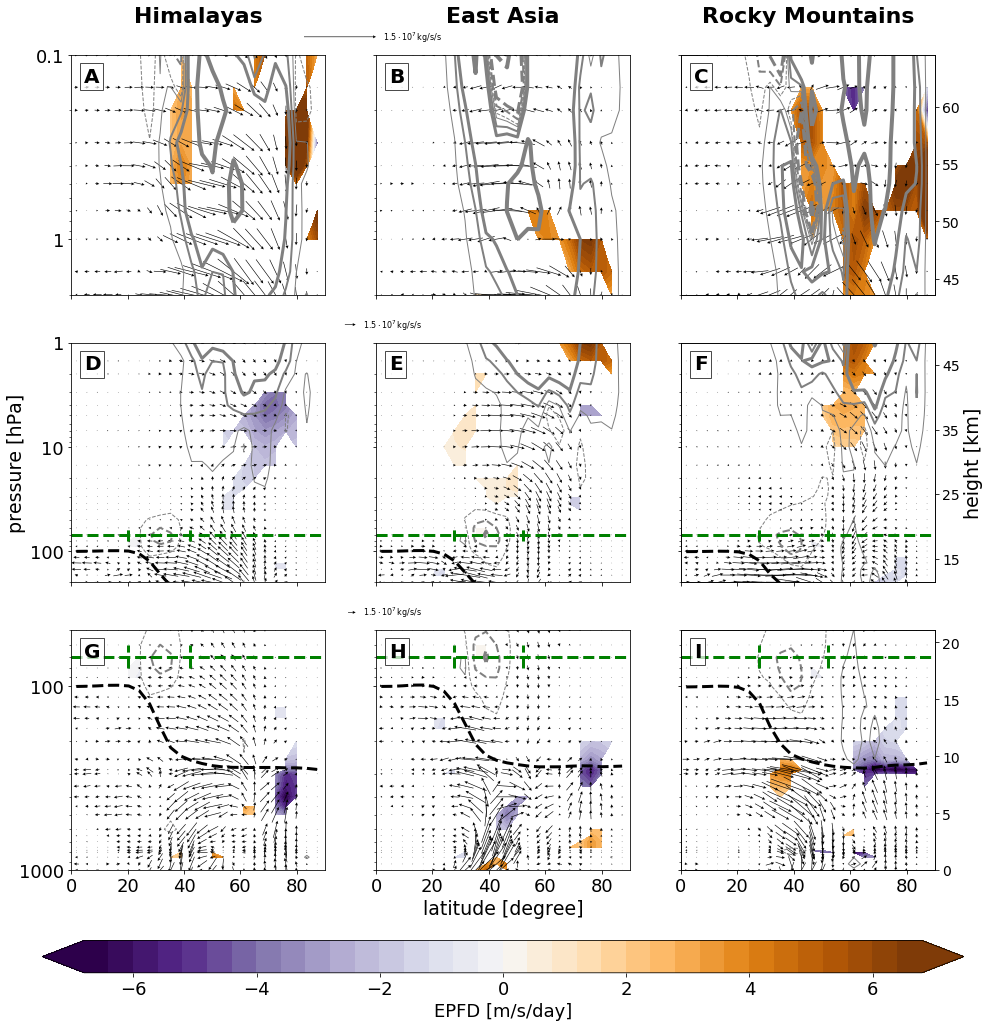

In [70]:
mpl.rcParams.update({'font.size': 18})

levels = [-5.0e+249, -3.8e+000, -3.4e+000, -3.0e+000, -2.6e+000, -2.2e+000,
       -1.8e+000, -1.4e+000, -1.0e+000, -6.0e-001, -2.0e-001,  2.0e-001,
        6.0e-001,  1.0e+000,  1.4e+000,  1.8e+000,  2.2e+000,  2.6e+000,
        3.0e+000,  3.4e+000,  3.8e+000,  5.0e+249]
levels = np.arange(-7.2,7.6,0.4)
titles = ['Himalayas', 'East Asia', 'Rocky Mountains'] #'West America']

mpl.rcParams.update({'font.size': 18})
sel_dict = dict(lat = slice(0,None), lag = 0)
trop_arr = da_trop['ptrop'].sel(**sel_dict).mean('lon')
sel_dict['plev'] = slice(None, 0.1)
carrf = ds_all['acceldiv'].where(da_pv_all < 0.05).sel(**sel_dict)*24*3600
carr =  ds_all['accelogw'].sel(**sel_dict).mean('lon')*24*3600
carr_sign = da_pv_all
qarr = ds_all[['fy', 'fz']].sel(**sel_dict)

scaling = xrf.sqrt(1000./qarr.plev)
three_row_subplot_fce(carrf, carr, qarr['fy']*scaling, qarr['fz']*scaling*100, trop_arr, levels, \
                      scaling = [1.5e7, 1e8, None], nos_lat = 1, nos_lev = 1)  # [1.5e7, 1e8, None]
plt.savefig('EPFD+EPfluxes_anomalies_all_20days_zm_wEPFDsignificancetropopause_DJFonly+alllayers.pdf', bbox_inches='tight')